In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

df = pd.read_csv("../datasets/AB_NYC_2019.csv")

In [40]:
df.shape

(48895, 16)

In [41]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

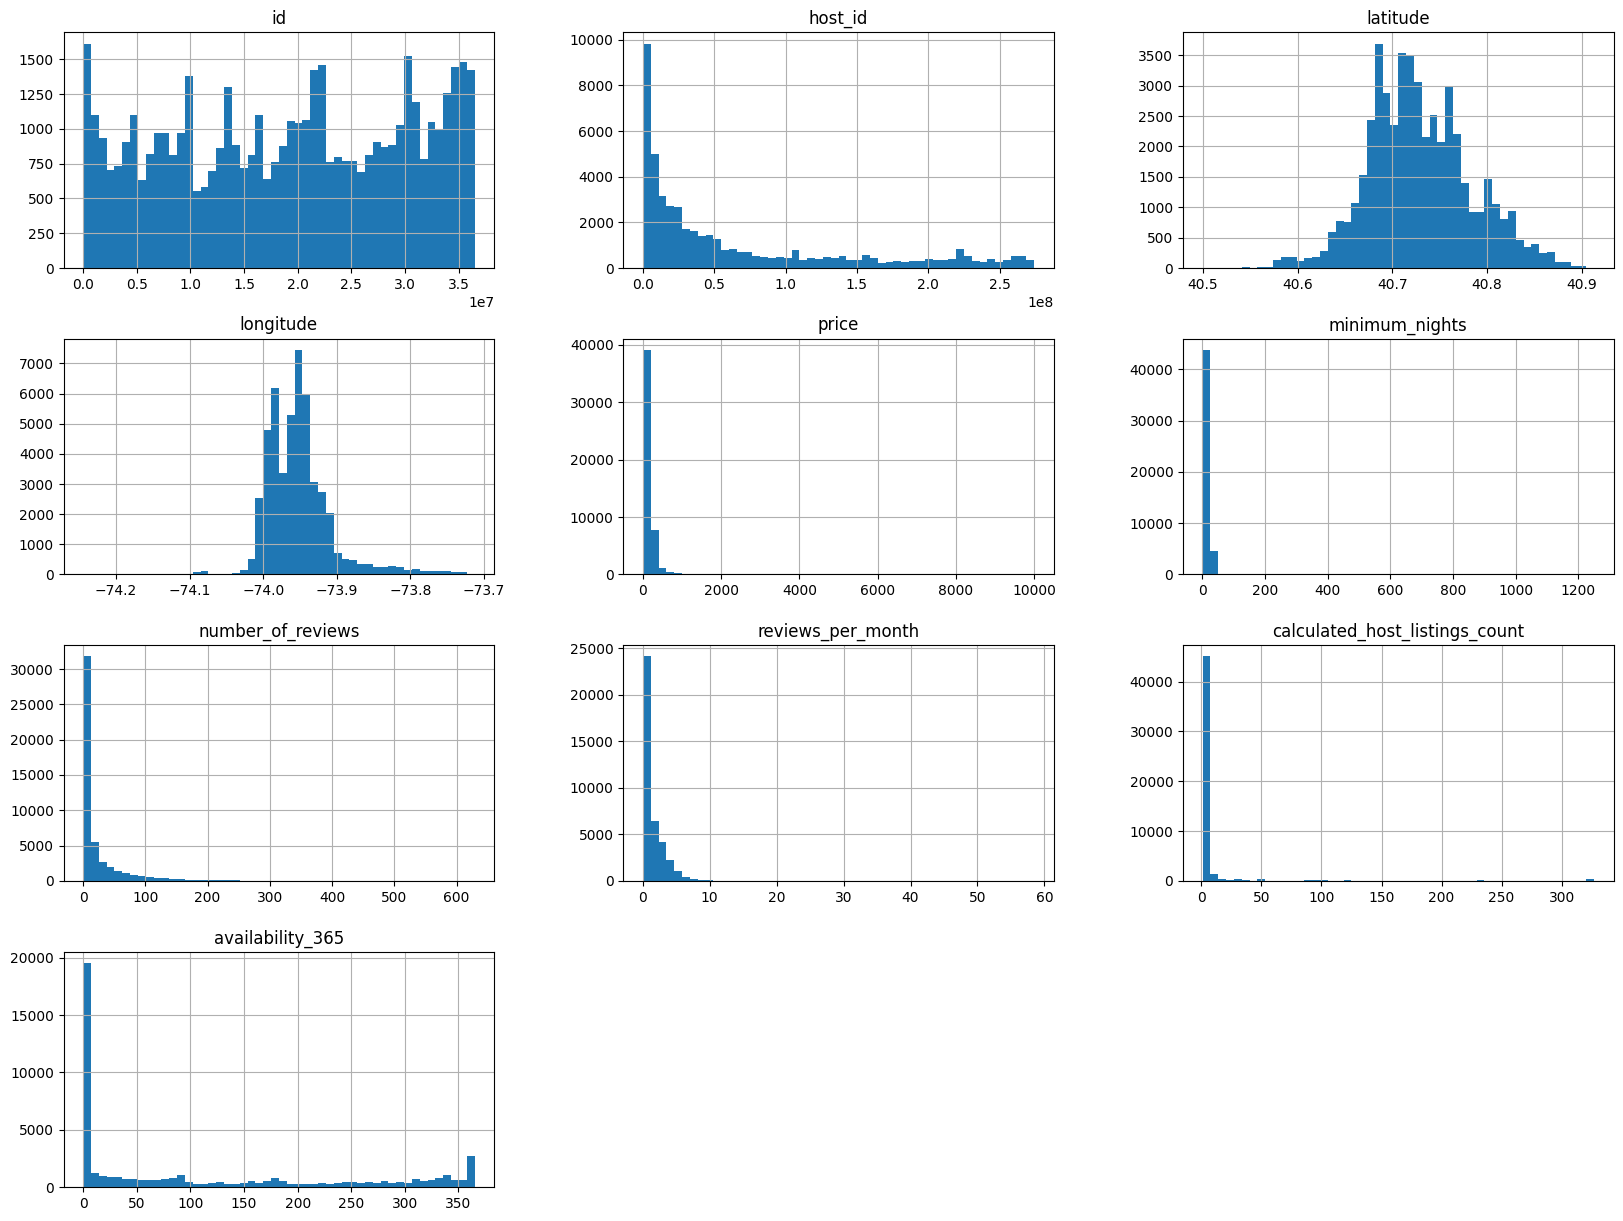

<Axes: xlabel='longitude', ylabel='latitude'>

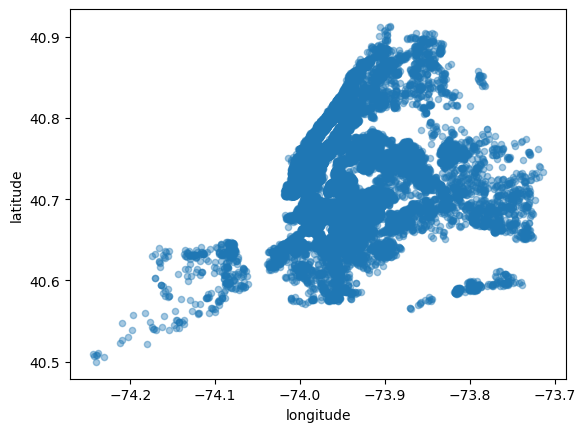

In [42]:
df.hist(bins=50, figsize=(20,15))
plt.show()

df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)

In [43]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [44]:
#Dropping columns that seem not relevant to make the price prediction 
df = df.drop(["id","last_review","name","host_name"],axis=1)

#Filling NaN columns in review_per_month with 0 as value
df["reviews_per_month"] = df["reviews_per_month"].fillna(0.0)

#Log transformation of price column to reduce skewness
log_price = np.log1p(df["price"])
df["log_price"] = log_price

In [45]:
features = ['neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365']

X = df[features]
y = df["log_price"]

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X["neighbourhood_group"]
)

In [47]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_cols = ["latitude","longitude","minimum_nights","number_of_reviews",
            "reviews_per_month","calculated_host_listings_count","availability_365"]
cat_cols = ["neighbourhood_group","room_type"]

preprocess = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

In [50]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def eval_model(name, est):
    pipe = Pipeline([("prep", preprocess), ("model", est)])
    pipe.fit(X_train, y_train)
    y_true = np.expm1(y_test.to_numpy())
    y_pred = np.expm1(pipe.predict(X_test))
    return {
        "model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }, (y_true, y_pred)

models = [
    ("Baseline (median)", DummyRegressor(strategy="median")),
    ("Ridge (alpha=1)", Ridge(alpha=1.0, max_iter=900, random_state=0)),
    ("ElasticNet (a=0.01,l1=0.5)", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=1500, random_state=0)),
    ("HistGB (depth=6,iters=50)", HistGradientBoostingRegressor(max_depth=6, max_iter=50, learning_rate=0.1, random_state=0)),
]

res, preds = [], {}
for n, est in models:
    m, p = eval_model(n, est)
    res.append(m); preds[n] = p

res_df = pd.DataFrame(res).sort_values("MAE").reset_index(drop=True)
print(res_df)

                        model        MAE          RMSE        R2
0   HistGB (depth=6,iters=50)  60.414155  50628.851587  0.148439
1             Ridge (alpha=1)  65.767185  54083.065333  0.090340
2  ElasticNet (a=0.01,l1=0.5)  66.080563  54574.270340  0.082079
3           Baseline (median)  86.513958  61882.490439 -0.040843


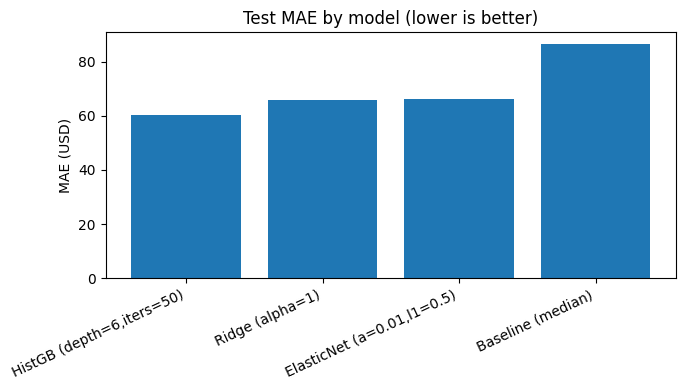

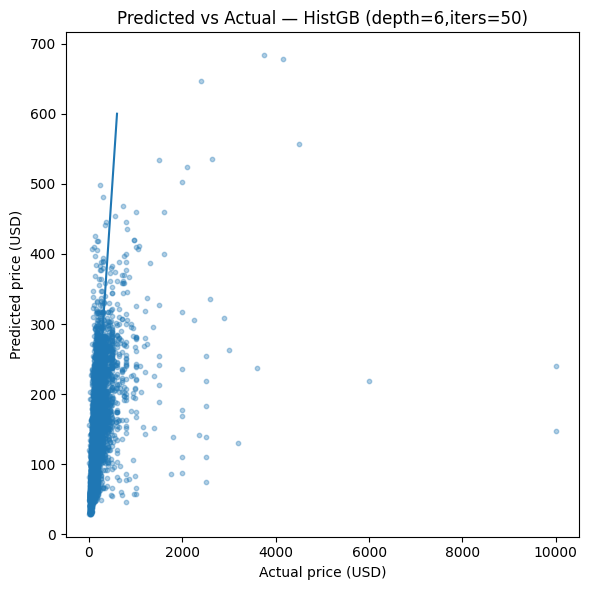

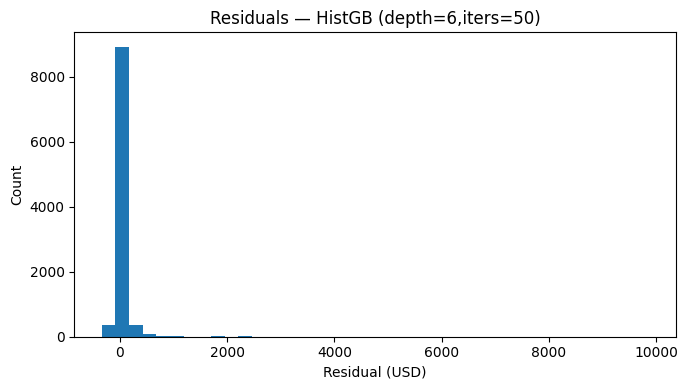

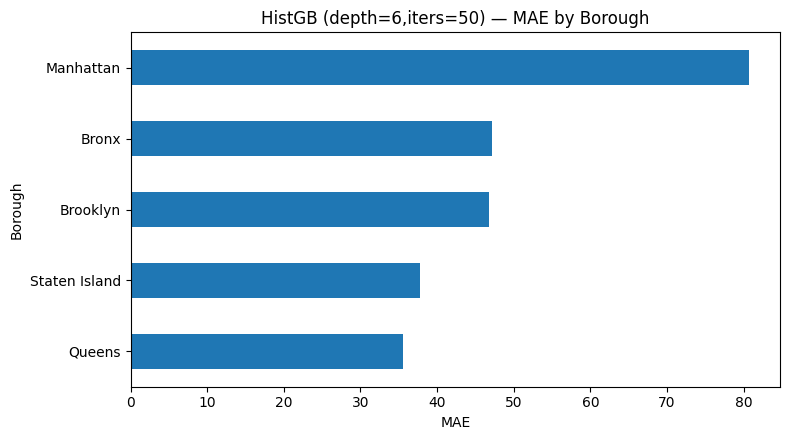

In [55]:
# Visualizations for model performance
# Bar plot for MAE by model
plt.figure(figsize=(7,4))
plt.bar(res_df["model"], res_df["MAE"])
plt.title("Test MAE by model (lower is better)"); plt.ylabel("MAE (USD)")
plt.xticks(rotation=25, ha="right"); plt.tight_layout(); plt.show()

best = res_df.iloc[0]["model"]
y_true, y_pred = preds[best]

# Scatter plot of predicted vs actual prices
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=10, alpha=0.35)
low, high = np.percentile(np.r_[y_true, y_pred], [1,99])
plt.plot([low, high], [low, high])
plt.xlabel("Actual price (USD)"); plt.ylabel("Predicted price (USD)")
plt.title(f"Predicted vs Actual — {best}"); plt.tight_layout(); plt.show()

# Histogram of residuals
plt.figure(figsize=(7,4))
plt.hist(y_true - y_pred, bins=40)
plt.title(f"Residuals — {best}"); plt.xlabel("Residual (USD)"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# MAE by borough
BOROUGH_COL = "neighbourhood_group"
borough = X_test[BOROUGH_COL].to_numpy()
abs_err = np.abs(y_true - y_pred)

df = pd.DataFrame({"borough": borough, "abs_err": abs_err})
per_borough_mae = df.groupby("borough")["abs_err"].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 4.5))
per_borough_mae.sort_values(ascending=True).plot(kind="barh")
plt.xlabel("MAE")
plt.ylabel("Borough")
plt.title(f"{best} — MAE by Borough")
plt.tight_layout()
plt.show()

